In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
#ae = pd.read_excel('..\data\Sample Data AgencyExpress (1% sample Georgia).xlsx')
amx_lines = pd.read_excel(r'C:\Users\Admin\OneDrive\Documents\Python Codes\techbridge24\cleaning\Choice Data.xlsx', sheet_name='AMX_OFFER_LINES')
amx_header = pd.read_excel(r'C:\Users\Admin\OneDrive\Documents\Python Codes\techbridge24\cleaning\Choice Data.xlsx', sheet_name='AMX_OFFER_HEADER')

In [3]:
amx_lines = amx_lines[['OFFERNUMBER', 'PRODUCTTYPECODE', 'QUANTITY', 'TOTALGROSSWEIGHT']]
print(amx_lines.shape)
amx_header = amx_header[['OFFERNUMBER', 'OFFERDATE']]
print(amx_header.shape)

(359978, 4)
(46509, 2)


In [5]:
amx = pd.merge(amx_lines, amx_header, on='OFFERNUMBER')
display(amx)

,OFFERNUMBER,PRODUCTTYPECODE,QUANTITY,TOTALGROSSWEIGHT,OFFERDATE
0,N059273,BP,21.0,493.50,04/10/2003
1,N059274,COND,231.0,2852.85,04/10/2003
2,N060118,BP,12.0,60.00,04/21/2003
3,N060118,BP,24.0,120.00,04/21/2003
4,N052341,MIX,1441.0,10040.00,02/19/2003
...,...,...,...,...,...
359942,N26060401,DAIRY,1.0,6.56,10/15/2024
359943,N26060401,MEAT,20.0,552.96,10/15/2024
359944,N26060401,DSRT,201.0,660.29,10/15/2024
359945,N26060401,MEAT,30.0,62.22,10/15/2024


In [6]:
amx['OFFERDATE'] = pd.to_datetime(amx['OFFERDATE'])
amx = amx[amx['OFFERDATE'].dt.year >= 2015]
#amx['QUARTER_YEAR'] = amx['OFFERDATE'].dt.to_period('Q')
display(amx)

,OFFERNUMBER,PRODUCTTYPECODE,QUANTITY,TOTALGROSSWEIGHT,OFFERDATE
135627,N6167646,BABY,68.0,394.00,2015-02-26
135628,N6167646,BABY,1265.0,4630.00,2015-02-26
135629,N6167646,BABY,3.0,9.00,2015-02-26
135630,N6167646,BABY,29.0,98.00,2015-02-26
135631,N6167646,BABY,60.0,121.00,2015-02-26
...,...,...,...,...,...
359942,N26060401,DAIRY,1.0,6.56,2024-10-15
359943,N26060401,MEAT,20.0,552.96,2024-10-15
359944,N26060401,DSRT,201.0,660.29,2024-10-15
359945,N26060401,MEAT,30.0,62.22,2024-10-15


In [8]:
amx_grouped = amx.groupby([pd.Grouper(key='OFFERDATE', freq='W'), 'PRODUCTTYPECODE'])['QUANTITY'].sum().reset_index()

amx_pivot = amx_grouped.pivot(index='OFFERDATE', columns='PRODUCTTYPECODE', values='QUANTITY').fillna(0)

amx_pivot_filtered = amx_pivot[['BEV', 'VEG', 'MEAT', 'DAIRY']].copy()
amx_pivot_filtered.index.name = 'OFFERDATE'  # ensure index label is kept
amx_pivot_filtered = amx_pivot[['BEV', 'VEG', 'MEAT', 'DAIRY']].reset_index()

# Function to remove outliers using the IQR method
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Remove outliers for BEV, MEAT, VEG, and DAIRY
for col in ['BEV', 'MEAT', 'VEG', 'DAIRY']:
    if col in amx_pivot_filtered.columns:
        amx_pivot_filtered = remove_outliers_iqr(amx_pivot_filtered, col)

display(amx_pivot_filtered)

PRODUCTTYPECODE,OFFERDATE,BEV,VEG,MEAT,DAIRY
0,2015-01-11,1485.0,40.0,71.0,173.0
1,2015-01-18,0.0,0.0,4138.0,972.0
4,2015-02-08,2724.0,16.0,200.0,78.0
5,2015-02-15,477.0,3.0,1206.0,154.0
7,2015-03-01,2671.0,2.0,532.0,2079.0
...,...,...,...,...,...
482,2024-04-07,0.0,0.0,2200.0,0.0
484,2024-04-21,0.0,0.0,1100.0,0.0
485,2024-04-28,80.0,0.0,0.0,0.0
487,2024-05-12,1344.0,0.0,509.0,0.0


In [9]:
#List out all of the economic dataset here:
nasdaq = pd.read_csv(r'C:\Users\Admin\OneDrive\Documents\Python Codes\techbridge24\NASDAQCOM.csv')
ppi = pd.read_csv(r'C:\Users\Admin\OneDrive\Documents\Python Codes\techbridge24\PPI-Grocery.csv')
ppi.rename(columns={'PCU445110445110': 'PPI'}, inplace=True)
dowjones = pd.read_csv(r'C:\Users\Admin\OneDrive\Documents\Python Codes\techbridge24\daily,_close.csv')
dowjones.rename(columns={'DJIA': 'DowJones'}, inplace=True)
sp500 = pd.read_csv(r'C:\Users\Admin\OneDrive\Documents\Python Codes\techbridge24\S&P 500 Weekly Data.csv')
ins_claim = pd.read_excel(r'C:\Users\Admin\OneDrive\Documents\Python Codes\techbridge24\Georgia - Insurance Claim Rate.xlsx')

In [10]:
from pandas import Timedelta

# Step 1: Convert all date columns to datetime format explicitly
amx_pivot_filtered['OFFERDATE'] = pd.to_datetime(amx_pivot_filtered['OFFERDATE'])
ppi['observation_date'] = pd.to_datetime(ppi['observation_date'], errors='coerce')
nasdaq['observation_date'] = pd.to_datetime(nasdaq['observation_date'], errors='coerce')
dowjones['observation_date'] = pd.to_datetime(dowjones['observation_date'], errors='coerce')
sp500['Date'] = pd.to_datetime(sp500['Date'], errors='coerce')
ins_claim['Filed week ended'] = pd.to_datetime(ins_claim['Filed week ended'], errors='coerce')

# Step 2: Sort AFTER conversion
amx_pivot_filtered = amx_pivot_filtered.sort_values('OFFERDATE')
ppi = ppi.sort_values('observation_date')
nasdaq = nasdaq.sort_values('observation_date')
dowjones = dowjones.sort_values('observation_date')
sp500 = sp500.sort_values('Date')  # this must be after conversion
ins_claim = ins_claim.sort_values('Filed week ended')


# Step 3: Merge using merge_asof with ±7-day tolerance
amx_pivot_merge = pd.merge_asof(
    amx_pivot_filtered, ppi,
    left_on='OFFERDATE', right_on='observation_date',
    tolerance=Timedelta('7D'), direction='nearest'
)

amx_pivot_merge = pd.merge_asof(
    amx_pivot_merge, nasdaq,
    left_on='OFFERDATE', right_on='observation_date',
    tolerance=Timedelta('7D'), direction='nearest'
)

amx_pivot_merge = pd.merge_asof(
    amx_pivot_merge, dowjones,
    left_on='OFFERDATE', right_on='observation_date',
    tolerance=Timedelta('7D'), direction='nearest'
)

amx_pivot_merge = pd.merge_asof(
    amx_pivot_merge, sp500,
    left_on='OFFERDATE', right_on='Date',
    tolerance=Timedelta('7D'), direction='nearest'
)

amx_pivot_merge = pd.merge_asof(
    amx_pivot_merge, ins_claim,
    left_on='OFFERDATE', right_on='Filed week ended',
    tolerance=Timedelta('7D'), direction='nearest'
)

In [11]:
#Clean and remove the sp500 fields, may check later
# Step 1: Ensure OFFERDATE is in datetime format
amx_pivot_merge['OFFERDATE'] = pd.to_datetime(amx_pivot_merge['OFFERDATE'])

# Step 2: Filter for rows from April 12, 2015 onwards
amx_pivot_merge = amx_pivot_merge[amx_pivot_merge['OFFERDATE'] >= '2015-04-12']

# Step 3: Drop the columns 'Date' and 'Close' if they exist
amx_pivot_merge = amx_pivot_merge.drop(columns=['Date', 'Close','observation_date_x','PPI'], errors='ignore')

In [12]:
amx_pivot_merge[['NASDAQCOM', 'DowJones', 'Insured Unemployment Rate']] = (
    amx_pivot_merge[['NASDAQCOM', 'DowJones', 'Insured Unemployment Rate']].ffill()
)

display(amx_pivot_merge)

,OFFERDATE,BEV,VEG,MEAT,DAIRY,observation_date_y,NASDAQCOM,observation_date,DowJones,Filed week ended,Insured Unemployment Rate
7,2015-04-12,684.0,0.0,641.0,860.0,2015-04-13,4988.25,2015-04-13,17977.04,2015-04-11,0.92
8,2015-05-03,5221.0,11.0,2957.0,2638.0,2015-05-04,5016.93,2015-05-04,18070.40,2015-05-02,0.90
9,2015-05-10,30.0,1156.0,650.0,424.0,2015-05-11,4993.57,2015-05-11,18105.17,2015-05-09,0.92
10,2015-05-24,459.0,1383.0,215.0,1122.0,2015-05-25,4993.57,2015-05-25,18105.17,2015-05-23,0.93
11,2015-05-31,800.0,0.0,134.0,34.0,2015-06-01,5082.93,2015-06-01,18040.37,2015-05-30,0.95
...,...,...,...,...,...,...,...,...,...,...,...
342,2024-04-07,0.0,0.0,2200.0,0.0,2024-04-08,16253.96,2024-04-08,38892.80,2024-04-06,0.63
343,2024-04-21,0.0,0.0,1100.0,0.0,2024-04-22,15451.31,2024-04-22,38239.98,2024-04-20,0.62
344,2024-04-28,80.0,0.0,0.0,0.0,2024-04-29,15983.08,2024-04-29,38386.09,2024-04-27,0.61
345,2024-05-12,1344.0,0.0,509.0,0.0,2024-05-13,16388.24,2024-05-13,39431.51,2024-05-11,0.61


In [13]:
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pandas as pd

# Features and targets
features = ['NASDAQCOM', 'DowJones', 'Insured Unemployment Rate']
targets = ['BEV', 'VEG', 'MEAT', 'DAIRY']

# Dictionary to hold results
results = {}

# For each target (BEV, VEG, MEAT, DAIRY)
for target in targets:
    # Step 1: Prepare X and y
    X = amx_pivot_merge[features].copy()
    y = amx_pivot_merge[target].copy()

    # Step 2: Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Step 3: Fit Linear Regression to predict actual values
    lin_reg = LinearRegression()
    lin_reg.fit(X_train, y_train)
    y_pred = lin_reg.predict(X_test)

    # Step 4: Create a binary classification label: 1 if prediction >= actual, else 0
    classification_label = (y_pred >= y_test).astype(int)

    # Step 5: Train Logistic Regression model using X_test to predict this binary result
    clf = LogisticRegression()
    clf.fit(X_test, classification_label)

    # Step 6: Predict using logistic regression and check accuracy
    y_class_pred = clf.predict(X_test)
    acc = accuracy_score(classification_label, y_class_pred)

    # Save results
    results[target] = {
        'linear_model': lin_reg,
        'logistic_model': clf,
        'accuracy': acc
    }

    print(f"{target} - Logistic Model Accuracy: {acc:.2f}")

BEV - Logistic Model Accuracy: 0.69
VEG - Logistic Model Accuracy: 0.69
MEAT - Logistic Model Accuracy: 0.66
DAIRY - Logistic Model Accuracy: 0.59


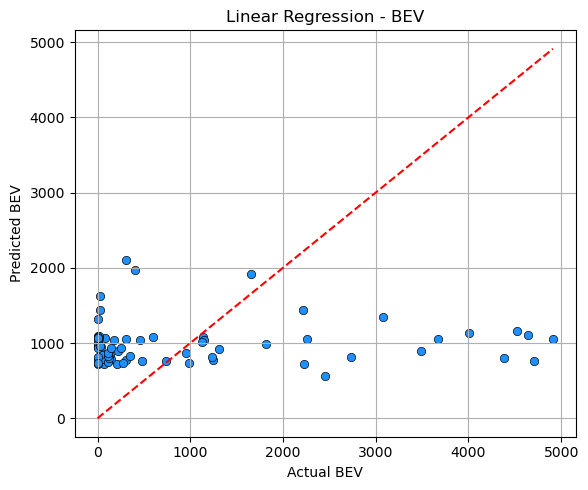

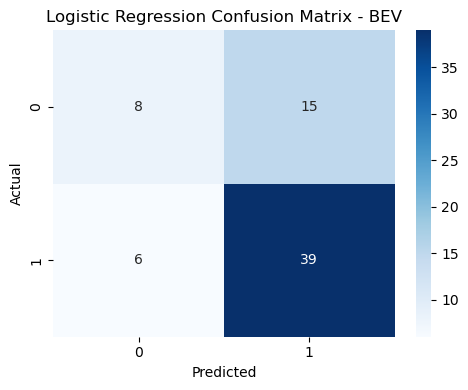

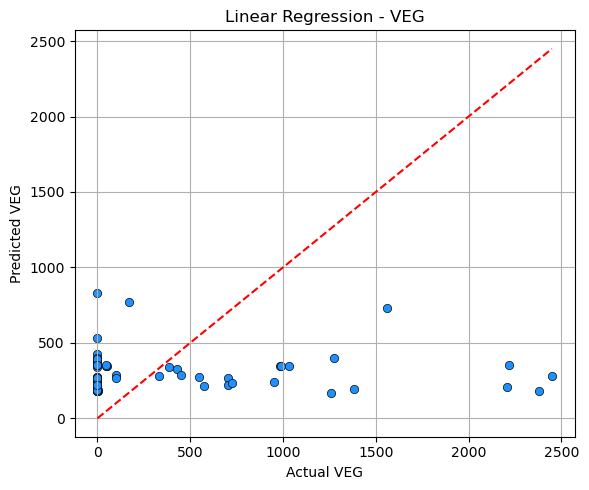

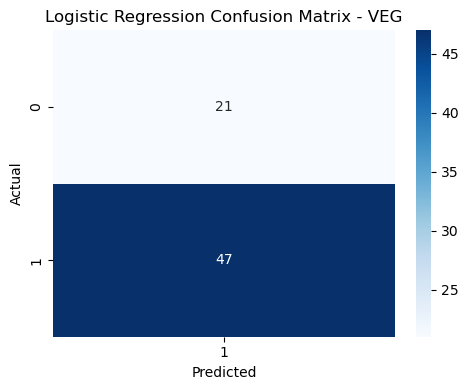

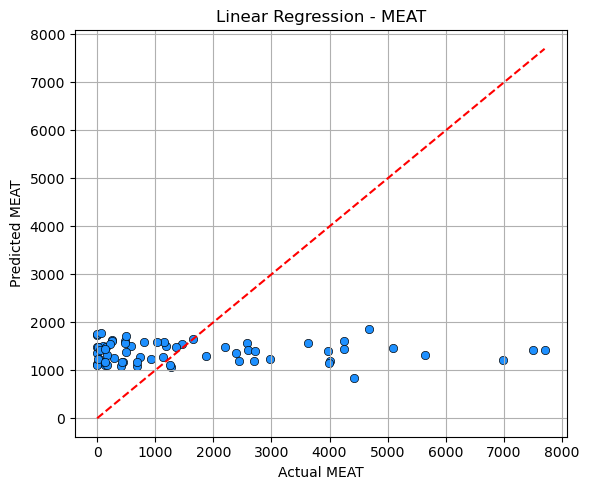

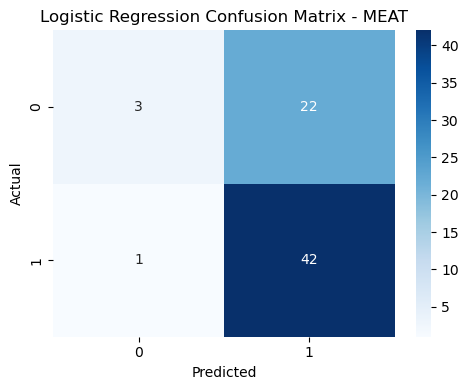

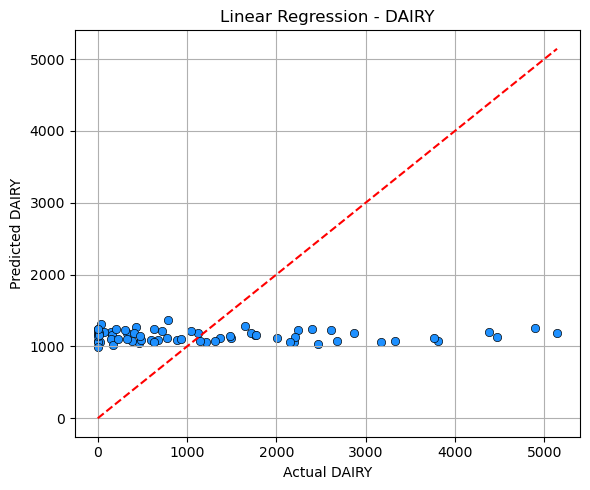

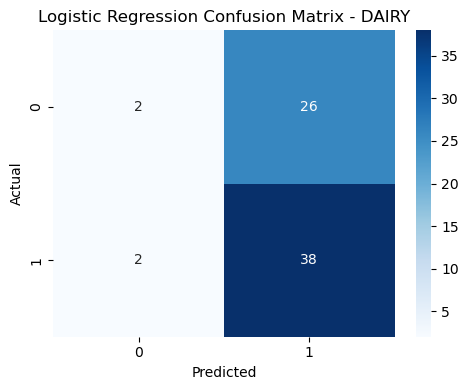

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

for target in targets:
    lin_reg = results[target]['linear_model']
    clf = results[target]['logistic_model']

    # Prepare test data again for plotting
    X = amx_pivot_merge[features]
    y = amx_pivot_merge[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # --- Plot 1: Linear Regression (Actual vs. Predicted) ---
    y_pred_lin = lin_reg.predict(X_test)

    plt.figure(figsize=(6, 5))
    sns.scatterplot(x=y_test, y=y_pred_lin, color='dodgerblue', edgecolor='black')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Ideal line
    plt.xlabel('Actual ' + target)
    plt.ylabel('Predicted ' + target)
    plt.title(f'Linear Regression - {target}')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # --- Plot 2: Logistic Regression (Prediction Classification) ---
    actual_class = (y_pred_lin >= y_test).astype(int)
    predicted_class = clf.predict(X_test)

    plt.figure(figsize=(5, 4))
    sns.heatmap(
        pd.crosstab(actual_class, predicted_class, rownames=['Actual'], colnames=['Predicted']),
        annot=True, fmt='d', cmap='Blues'
    )
    plt.title(f'Logistic Regression Confusion Matrix - {target}')
    plt.tight_layout()
    plt.show()